# BTC Stochastic + BTC/ETH Ratio Linear Combo

This notebook builds:
1. A **BTC stochastic long/flat model**.
2. A **BTC-vs-ETH ratio long/flat model** (based on spread z-score).
3. An optimized **linear combo** of both models.

Then it compares all strategies against **BTC** and **ETH** buy-and-hold, including Sharpe.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
def load_crypto_data() -> pd.DataFrame:
    candidates = [
        Path("../Market Data/Crypto Data/cleaned_crypto_data.csv"),
        Path("Market Data/Crypto Data/cleaned_crypto_data.csv"),
    ]
    for p in candidates:
        if p.exists():
            df = pd.read_csv(p)
            break
    else:
        raise FileNotFoundError("cleaned_crypto_data.csv not found")

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").set_index("Date")

    keep = ["BTC-USD_close", "ETH-USD_close", "BTC_REWARD", "COST_TO_MINE"]
    for c in keep:
        if c not in df.columns:
            raise KeyError(f"Missing required column: {c}")

    out = df[keep].rename(columns={
        "BTC-USD_close": "btc",
        "ETH-USD_close": "eth",
        "BTC_REWARD": "reward",
        "COST_TO_MINE": "cost_to_mine",
    }).dropna()

    return out


df = load_crypto_data()
df.head()


,btc,eth,reward,cost_to_mine
Date,,,,
2008-01-01,424.440002,307.907989,50.0,177.2767
2008-01-02,424.440002,307.907989,50.0,177.2767
2008-01-03,424.440002,307.907989,50.0,177.2767
2008-01-04,424.440002,307.907989,50.0,177.2767
2008-01-05,424.440002,307.907989,50.0,177.2767


In [3]:
TRADING_DAYS = 252


def sharpe_ratio(daily_returns: pd.Series, periods: int = TRADING_DAYS) -> float:
    r = daily_returns.dropna()
    if len(r) < 2:
        return np.nan
    vol = r.std(ddof=1)
    if vol == 0 or not np.isfinite(vol):
        return np.nan
    return float((r.mean() / vol) * np.sqrt(periods))


def max_drawdown(daily_returns: pd.Series) -> float:
    r = daily_returns.fillna(0.0)
    eq = (1 + r).cumprod()
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())


def summarize(daily_returns: pd.Series, name: str) -> dict:
    r = daily_returns.dropna()
    eq = (1 + r).cumprod()
    total = float(eq.iloc[-1] - 1.0) if len(eq) else np.nan
    ann_ret = float((1 + total) ** (TRADING_DAYS / len(r)) - 1.0) if len(r) else np.nan
    ann_vol = float(r.std(ddof=1) * np.sqrt(TRADING_DAYS)) if len(r) > 1 else np.nan
    sh = sharpe_ratio(r)
    mdd = max_drawdown(r)
    calmar = float(ann_ret / abs(mdd)) if np.isfinite(ann_ret) and np.isfinite(mdd) and mdd < 0 else np.nan
    return {
        "strategy": name,
        "total_return": total,
        "annualized_return": ann_ret,
        "annualized_vol": ann_vol,
        "sharpe": sh,
        "max_drawdown": mdd,
        "calmar": calmar,
    }


In [4]:
def build_stochastic_signal(price: pd.Series, k_window: int = 14, d_window: int = 3, oversold: float = 20.0, overbought: float = 80.0) -> pd.Series:
    low_k = price.rolling(k_window).min()
    high_k = price.rolling(k_window).max()
    pct_k = 100 * (price - low_k) / (high_k - low_k)
    pct_d = pct_k.rolling(d_window).mean()

    pos = pd.Series(index=price.index, data=0.0)
    in_pos = 0.0
    for i in range(len(price)):
        k = pct_k.iat[i]
        d = pct_d.iat[i]

        if not np.isfinite(k) or not np.isfinite(d):
            pos.iat[i] = in_pos
            continue

        if in_pos == 0.0:
            if (k > d) and (k < oversold):
                in_pos = 1.0
        else:
            if (k < d) and (k > overbought):
                in_pos = 0.0

        pos.iat[i] = in_pos

    return pos


def estimate_beta(log_btc: pd.Series, log_eth: pd.Series) -> float:
    x = log_eth.values
    y = log_btc.values
    x_mean = x.mean()
    y_mean = y.mean()
    denom = np.sum((x - x_mean) ** 2)
    if denom == 0:
        return 1.0
    return float(np.sum((x - x_mean) * (y - y_mean)) / denom)


def build_ratio_signal(btc: pd.Series, eth: pd.Series, lookback: int = 90, entry_z: float = 1.7, exit_z: float = 0.4) -> tuple[pd.Series, pd.Series]:
    log_btc = np.log(btc)
    log_eth = np.log(eth)
    beta = estimate_beta(log_btc.dropna(), log_eth.dropna())
    spread = log_btc - beta * log_eth

    m = spread.rolling(lookback).mean()
    s = spread.rolling(lookback).std(ddof=0).replace(0.0, np.nan)
    z = (spread - m) / s

    pos = pd.Series(index=spread.index, data=0.0)
    in_pos = 0.0
    for i in range(len(spread)):
        zi = z.iat[i]
        if not np.isfinite(zi):
            pos.iat[i] = in_pos
            continue

        if in_pos == 0.0 and zi < -entry_z:
            in_pos = 1.0
        elif in_pos == 1.0 and zi > -exit_z:
            in_pos = 0.0

        pos.iat[i] = in_pos

    return pos, spread


In [5]:
def backtest_weighted_long(price: pd.Series, weight: pd.Series, vol_target: float = 0.20, vol_lb: int = 20, max_leverage: float = 1.5) -> pd.Series:
    ret = price.pct_change().fillna(0.0)
    w = weight.reindex(price.index).fillna(0.0).clip(lower=0.0)

    realized = ret.rolling(vol_lb, min_periods=max(5, vol_lb // 3)).std(ddof=0) * np.sqrt(TRADING_DAYS)
    scale = (vol_target / realized).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    w = (w * scale).clip(upper=max_leverage)

    strat = w.shift(1).fillna(0.0) * ret
    return strat


def optimize_linear_combo(df: pd.DataFrame):
    btc = df["btc"]
    eth = df["eth"]

    rows = []
    best = {"score": -np.inf, "params": None, "returns": None, "weights": None}

    for k_window in [10, 14, 20]:
        for d_window in [3, 5]:
            stoch_pos = build_stochastic_signal(btc, k_window=k_window, d_window=d_window)

            for lookback in [60, 90, 120, 180]:
                for entry_z in [1.2, 1.5, 1.8, 2.1]:
                    for exit_z in [0.2, 0.4, 0.6]:
                        if exit_z >= entry_z:
                            continue

                        ratio_pos, _ = build_ratio_signal(btc, eth, lookback=lookback, entry_z=entry_z, exit_z=exit_z)

                        for w_stoch in np.linspace(0.0, 1.5, 16):
                            for w_ratio in np.linspace(0.0, 1.5, 16):
                                combo_weight = (w_stoch * stoch_pos + w_ratio * ratio_pos).clip(upper=2.0)
                                combo_ret = backtest_weighted_long(btc, combo_weight)
                                sh = sharpe_ratio(combo_ret)

                                if not np.isfinite(sh):
                                    continue

                                mdd = max_drawdown(combo_ret)
                                score = sh - 0.10 * abs(min(mdd, 0.0))

                                rows.append({
                                    "k_window": k_window,
                                    "d_window": d_window,
                                    "lookback": lookback,
                                    "entry_z": entry_z,
                                    "exit_z": exit_z,
                                    "w_stoch": float(w_stoch),
                                    "w_ratio": float(w_ratio),
                                    "sharpe": float(sh),
                                    "score": float(score),
                                    "max_drawdown": float(mdd),
                                })

                                if score > best["score"]:
                                    best = {
                                        "score": float(score),
                                        "params": {
                                            "k_window": k_window,
                                            "d_window": d_window,
                                            "lookback": lookback,
                                            "entry_z": float(entry_z),
                                            "exit_z": float(exit_z),
                                            "w_stoch": float(w_stoch),
                                            "w_ratio": float(w_ratio),
                                        },
                                        "returns": combo_ret,
                                        "weights": combo_weight,
                                    }

    return pd.DataFrame(rows).sort_values("score", ascending=False), best


In [6]:
search_df, best = optimize_linear_combo(df)
if best["params"] is None:
    raise RuntimeError("No valid combo found")

btc = df["btc"]
eth = df["eth"]

stoch_pos = build_stochastic_signal(
    btc,
    k_window=best["params"]["k_window"],
    d_window=best["params"]["d_window"],
)
ratio_pos, ratio_spread = build_ratio_signal(
    btc,
    eth,
    lookback=best["params"]["lookback"],
    entry_z=best["params"]["entry_z"],
    exit_z=best["params"]["exit_z"],
)

stoch_ret = backtest_weighted_long(btc, stoch_pos)
ratio_ret = backtest_weighted_long(btc, ratio_pos)
combo_ret = best["returns"]

btc_ret = btc.pct_change().fillna(0.0)
eth_ret = eth.pct_change().fillna(0.0)

metrics = pd.DataFrame([
    summarize(stoch_ret, "BTC Stochastic"),
    summarize(ratio_ret, "BTC/ETH Ratio"),
    summarize(combo_ret, "Linear Combo (Stoch + Ratio)"),
    summarize(btc_ret, "BTC Buy & Hold"),
    summarize(eth_ret, "ETH Buy & Hold"),
]).set_index("strategy")

print("Best combo params:", best["params"])
print("Best score:", round(best["score"], 4))
print(metrics[["sharpe", "annualized_return", "annualized_vol", "max_drawdown", "calmar"]].round(4))

combo_sharpe = metrics.loc["Linear Combo (Stoch + Ratio)", "sharpe"]
if np.isfinite(combo_sharpe) and combo_sharpe <= 1.04:
    print("Combo Sharpe is <= 1.04. Expand search ranges or add more regime filters.")
else:
    print("Combo Sharpe is above 1.04.")


Best combo params: {'k_window': 10, 'd_window': 3, 'lookback': 120, 'entry_z': 1.2, 'exit_z': 0.2, 'w_stoch': 0.0, 'w_ratio': 0.1}
Best score: 0.3318
                              sharpe  annualized_return  annualized_vol  \
strategy                                                                  
BTC Stochastic               -0.0240            -0.0130    1.382000e-01   
BTC/ETH Ratio                 0.3351             0.0330    1.173000e-01   
Linear Combo (Stoch + Ratio)  0.3351             0.0039    1.170000e-02   
BTC Buy & Hold                0.6613             0.2139    4.421000e-01   
ETH Buy & Hold                0.1952             1.0024    2.315260e+06   

                              max_drawdown  calmar  
strategy                                            
BTC Stochastic                     -0.6007 -0.0216  
BTC/ETH Ratio                      -0.2976  0.1110  
Linear Combo (Stoch + Ratio)       -0.0330  0.1171  
BTC Buy & Hold                     -0.8340  0.2565  
ETH Bu

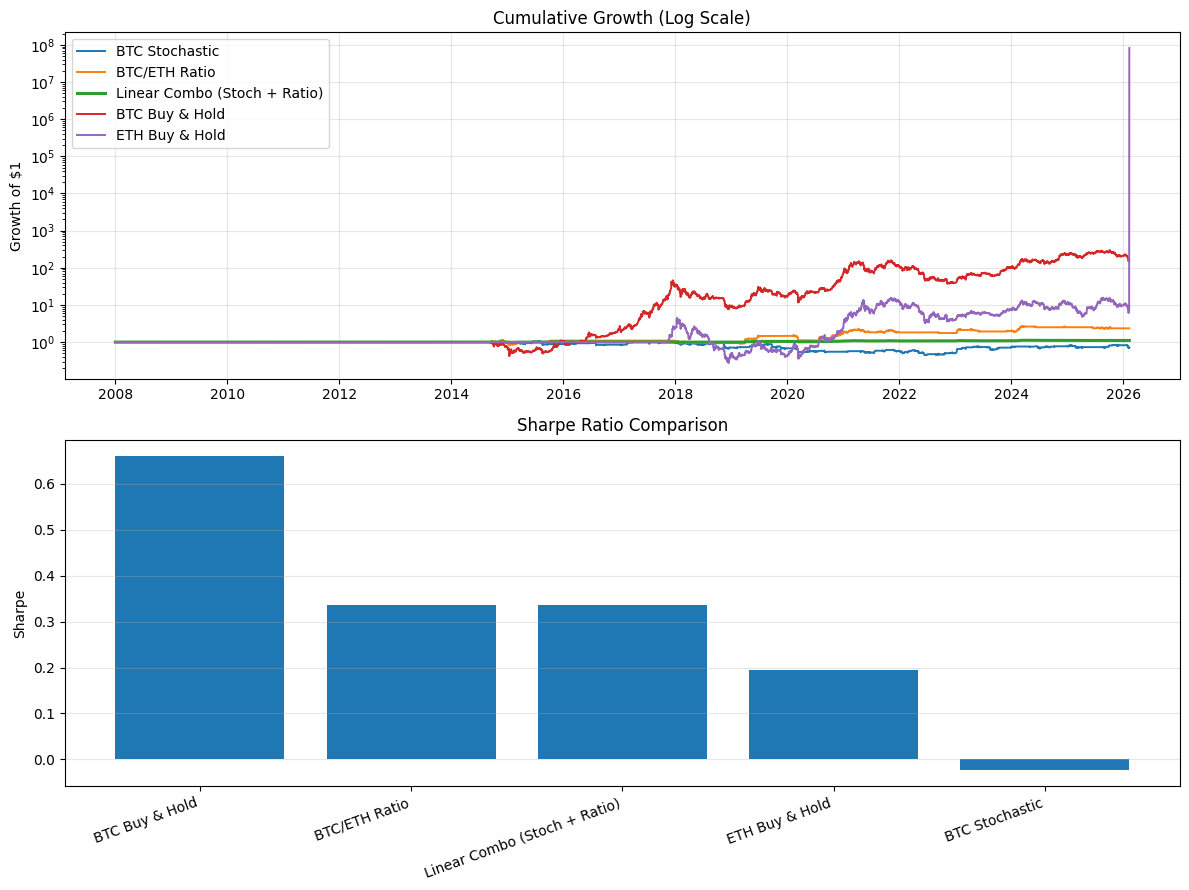

In [7]:
eq = pd.DataFrame({
    "BTC Stochastic": (1 + stoch_ret).cumprod(),
    "BTC/ETH Ratio": (1 + ratio_ret).cumprod(),
    "Linear Combo (Stoch + Ratio)": (1 + combo_ret).cumprod(),
    "BTC Buy & Hold": (1 + btc_ret).cumprod(),
    "ETH Buy & Hold": (1 + eth_ret).cumprod(),
}).dropna()

fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=False)

for col in eq.columns:
    lw = 2.2 if col == "Linear Combo (Stoch + Ratio)" else 1.4
    axes[0].plot(eq.index, eq[col], label=col, linewidth=lw)

axes[0].set_yscale("log")
axes[0].set_title("Cumulative Growth (Log Scale)")
axes[0].set_ylabel("Growth of $1")
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc="best")

sh = metrics["sharpe"].sort_values(ascending=False)
x = np.arange(len(sh))
axes[1].bar(x, sh.values)
axes[1].set_xticks(x)
axes[1].set_xticklabels(sh.index, rotation=20, ha="right")
axes[1].set_title("Sharpe Ratio Comparison")
axes[1].set_ylabel("Sharpe")
axes[1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
